# Performing a Sentiment Analysis of Energy Crude Oil Tweets

## Importing Libraries & Loading Dataset

In [48]:
#Generic Data Processing & Visualization Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re,string,unicodedata
import contractions #import contractions_dict
from bs4 import BeautifulSoup
%matplotlib inline


#Importing text processing libraries
import spacy
import spacy.cli
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

#downloading wordnet/punkt dictionary
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)

[nltk_data] Downloading package wordnet to /Users/jeudi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jeudi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jeudi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
#Loading Dataset
oil = pd.read_csv('oil_sentences.csv')
climate = pd.read_csv('climate_sentences.csv')
data = pd.read_csv('presidential_speeches.csv')

## Data Exploration

In [52]:
#Resetting Index
oil.reset_index(drop=True, inplace=True)
climate.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

In [53]:
#Backup of the newly created dataset
oil_backup = oil.copy()
climate_backup = climate.copy()
data_backup = data.copy()

In [54]:
oil.rename(columns={'oil_sentences':'text'}, inplace=True)
climate.rename(columns={'climate_sentences':'text'}, inplace=True)

## Text Cleaning

In [55]:
#lowering cases
oil['text'] = oil['text'].str.lower()
climate['text'] = climate['text'].str.lower()

In [56]:
#stripping leading spaces (if any)
oil['text'] = oil['text'].str.strip()
climate['text'] = climate['text'].str.strip()

In [57]:
# Removing HTML tags
def strip_html_tags(text):
    try:
        soup = BeautifulSoup(text, "html.parser")
        stripped_text = soup.get_text()
        return stripped_text
    except Exception as e:
        return text

#apply to the dataset
oil['text'] = oil['text'].apply(strip_html_tags)
climate['text'] = climate['text'].apply(strip_html_tags)



In [58]:
# Remove URL and links
def strip_url(text):
    try:
        strip_url_text = re.sub(r'http\S+', '', text)
        return strip_url_text
    except:
        return text

#Applying the dataset
oil['text'] = oil['text'].apply(strip_url)
climate['text'] = climate['text'].apply(strip_url)

In [59]:
oil.dropna(inplace=True)
climate.dropna(inplace=True)

In [60]:
#removing punctuations
from string import punctuation

def remove_punct(text):
  for punctuations in punctuation:
    text = text.replace(punctuations, '')
  return text

#apply to the dataset
oil['text'] = oil['text'].apply(remove_punct)
climate['text'] = climate['text'].apply(remove_punct)

In [61]:
#function to remove special characters
def remove_special_chars(text, remove_digits=True):
  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern, '', text)
  return text

#applying the function on the clean dataset
oil['text'] = oil['text'].apply(remove_special_chars)
climate['text'] = climate['text'].apply(remove_special_chars)

In [62]:
#function to remove macrons & accented characters
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

#applying the function on the clean dataset
oil['text'] = oil['text'].apply(remove_accented_chars)
climate['text'] = climate['text'].apply(remove_accented_chars)

In [63]:
#Function to expand contractions
def expand_contractions(con_text):
  con_text = contractions.fix(con_text)
  return con_text

#applying the function on the clean dataset
oil['text'] = oil['text'].apply(expand_contractions)
climate['text'] = climate['text'].apply(expand_contractions)

In [64]:
#creating a new column in the dataset for word count
oil['word_count'] = oil['text'].apply(lambda x:len(str(x).split(" ")))
climate['word_count'] = climate['text'].apply(lambda x:len(str(x).split(" ")))

In [65]:
#Taking Backup
oil_clean = oil.copy()
climate_clean = climate.copy()

## Text Preprocessing & Normalisation

### Removing Stop Words

In [66]:
#function to remove stopwords
def remove_stopwords(text, is_lower_case=False):
    stopword_list = set(stopwords.words('english'))
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#applying the function
oil['text'] = oil['text'].apply(remove_stopwords)
climate['text'] = climate['text'].apply(remove_stopwords)


### Stemming

In [67]:
#Function for stemming
def simple_stemmer(text):
  ps = nltk.porter.PorterStemmer()
  text = ' '.join([ps.stem(word) for word in text.split()])
  return text

#applying the function
oil['Stemd_text'] = oil['text'].apply(simple_stemmer)
climate['Stemd_text'] = climate['text'].apply(simple_stemmer)

In [68]:
#Taking Backup
oil_prepocessed = oil.copy()
climate_prepocessed = climate.copy()

## Sentiment Analysis - TextBlob Library

In [69]:
#Import Textblob Library
from textblob import TextBlob

In [70]:
#function to perform Textblob Sentiment Analyis
def sentiment_analysis(text):
    polarity = round(TextBlob(text).sentiment.polarity, 3)
    return polarity
        
#Apply to the Stemd_Text
oil['Sentiments'] = [sentiment_analysis(txt) for txt in oil['Stemd_text']]
climate['Sentiments'] = [sentiment_analysis(txt) for txt in climate['Stemd_text']]

## Analysis & Visualisation

### Distribution of Word Count

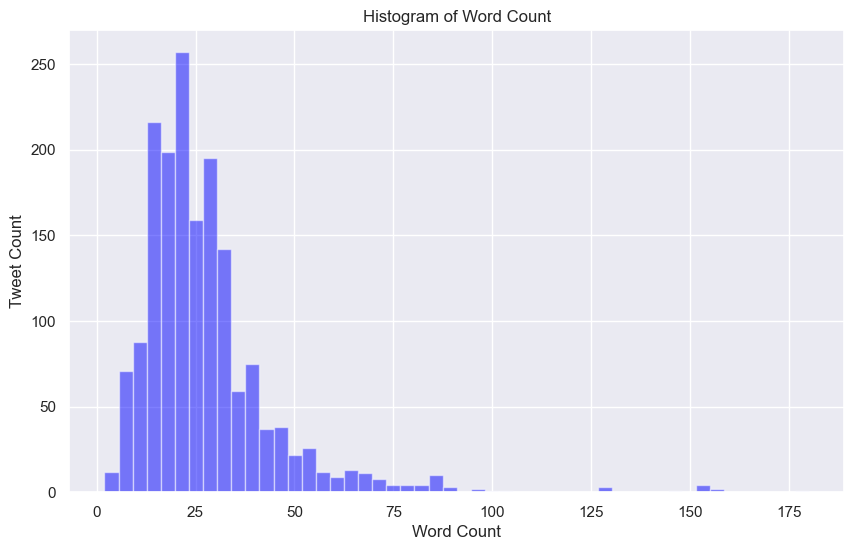

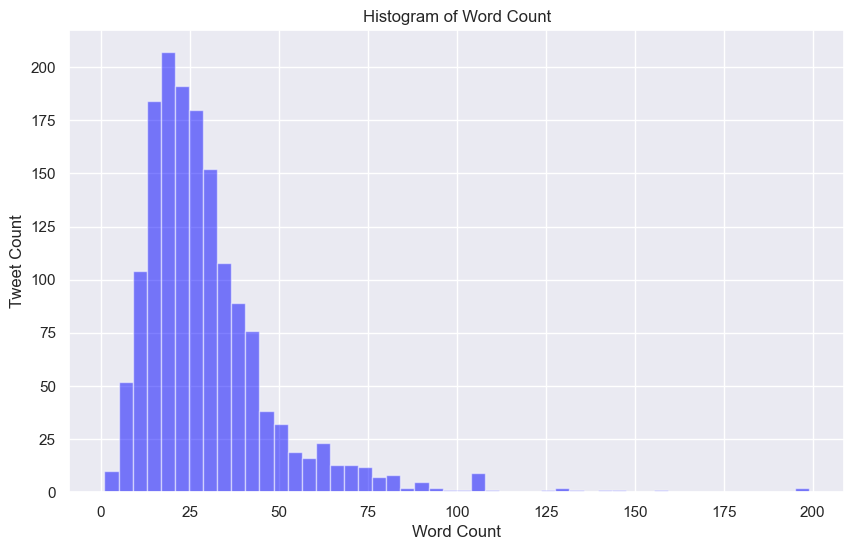

In [71]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(oil.word_count, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Word Count')
plt.ylabel('Tweet Count')
plt.title('Histogram of Word Count')
plt.show();

plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(climate.word_count, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Word Count')
plt.ylabel('Tweet Count')
plt.title('Histogram of Word Count')
plt.show();

**Analysis:** skewed to the right, centered at 25.

In [41]:
oil = pd.read_csv('oil_sentiment.csv')
climate = pd.read_csv('climate_sentiment.csv')

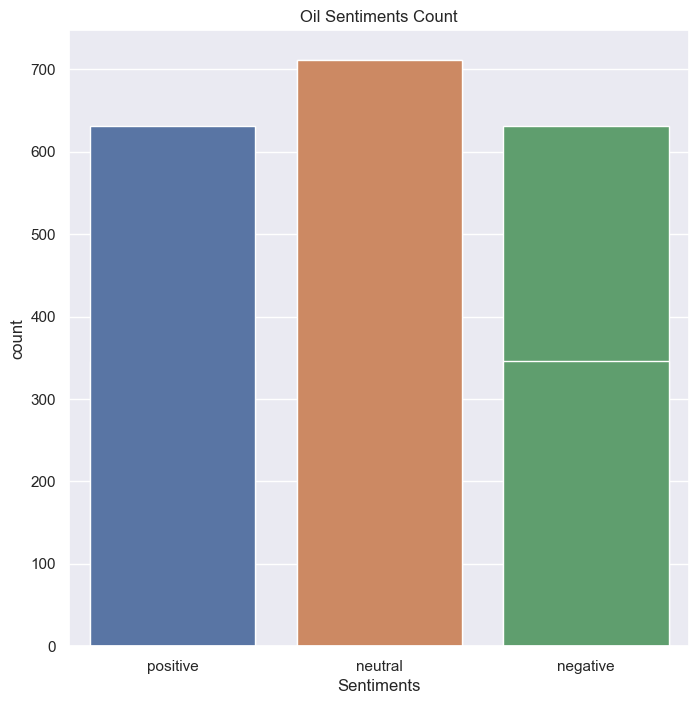

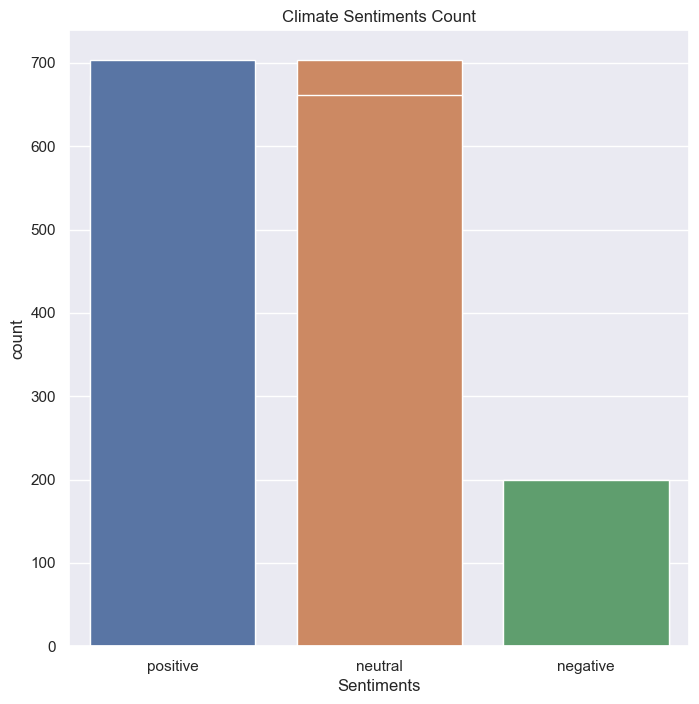

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
#Creating a Count Plot

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.countplot(x="Sentiments", data=oil)
plt.title('Oil Sentiments Count')
plt.ylabel('Count')
plt.xlabel('Sentiments')
ax = sns.countplot(x="Sentiments", data=oil, order=['positive','neutral','negative'])
plt.show();

#Creating a Count Plot
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.countplot(x="Sentiments", data=climate)
plt.title('Climate Sentiments Count')
plt.ylabel('Count')
plt.xlabel('Sentiments')
ax = sns.countplot(x="Sentiments", data=climate, order=['positive','neutral','negative'])
plt.show()

**Analysis:** Majority of the tweets are netural with 'negative' tweets being the second highest

In [32]:
data.head()

,screenName,text,Stemd_text,retweetCount,word_count,Sentiments
0,ArgusMedia,domestic output exceeding regional demand us c...,domest output exceed region demand us crudeoil...,0,17,neutral
1,macrohedged,friday us crude oil front 12 months futures pr...,friday us crude oil front 12 month futur price...,0,24,negative
2,El_Spy,rt aeberman12 opec pumped 296 mmbpd last month...,rt aeberman12 opec pump 296 mmbpd last month 1...,1,22,neutral
3,SuperiorMar,rt aeberman12 ships vanishing tracking screens...,rt aeberman12 ship vanish track screen clandes...,1,18,negative
4,aeberman12,opec pumped 296 mmbpd last month 170 kbd mays ...,opec pump 296 mmbpd last month 170 kbd may rev...,1,20,neutral


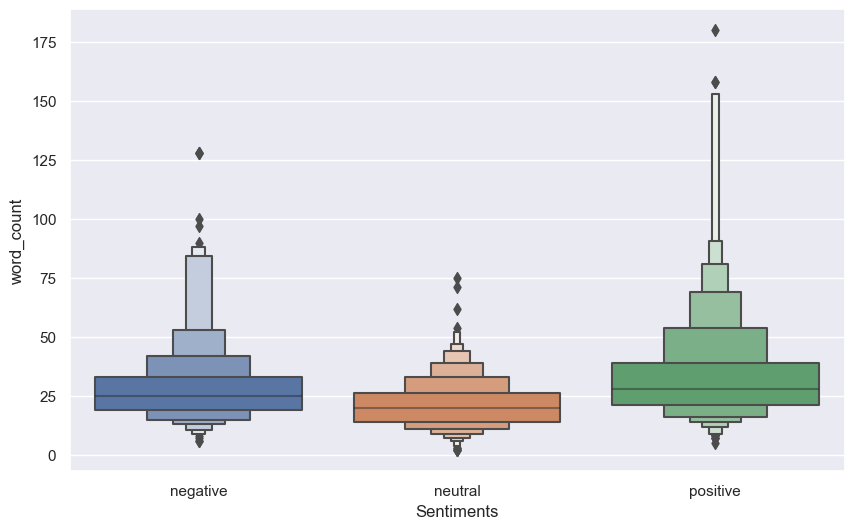

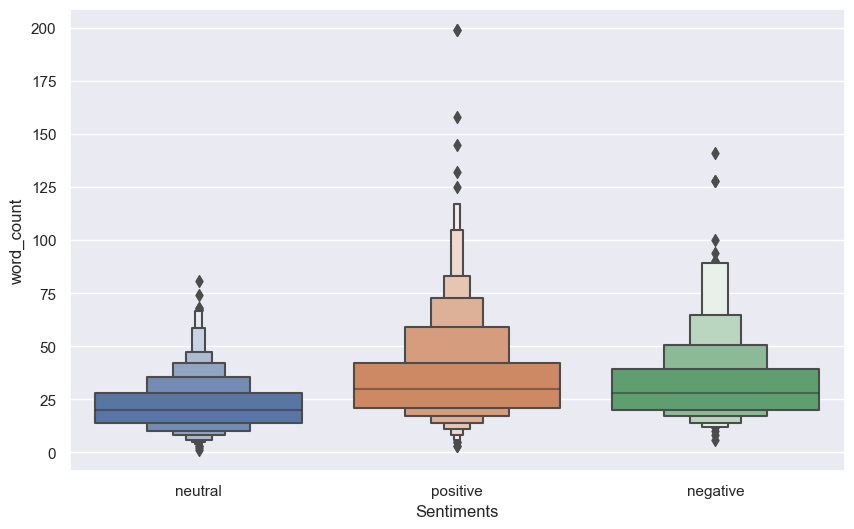

In [99]:
plt.figure(figsize=(10,6))
sns.boxenplot(x='Sentiments', y='word_count', data=oil)
plt.show();

plt.figure(figsize=(10,6))
sns.boxenplot(x='Sentiments', y='word_count', data=climate)
plt.show();

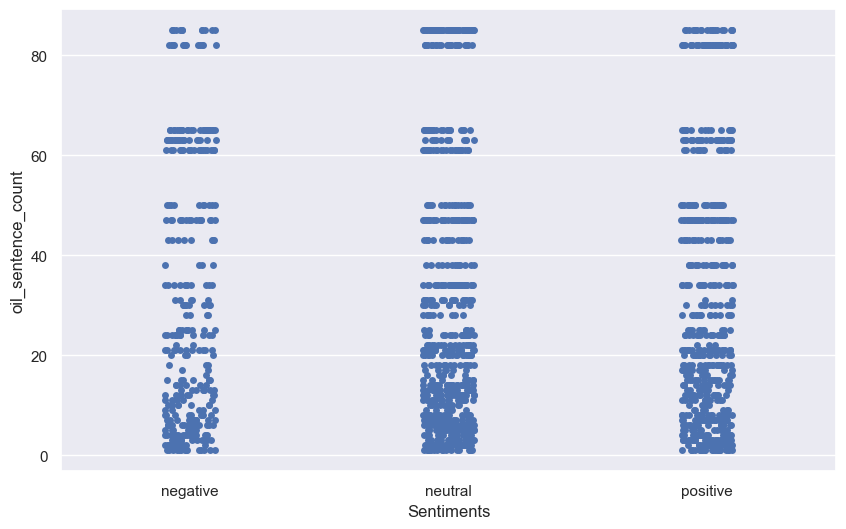

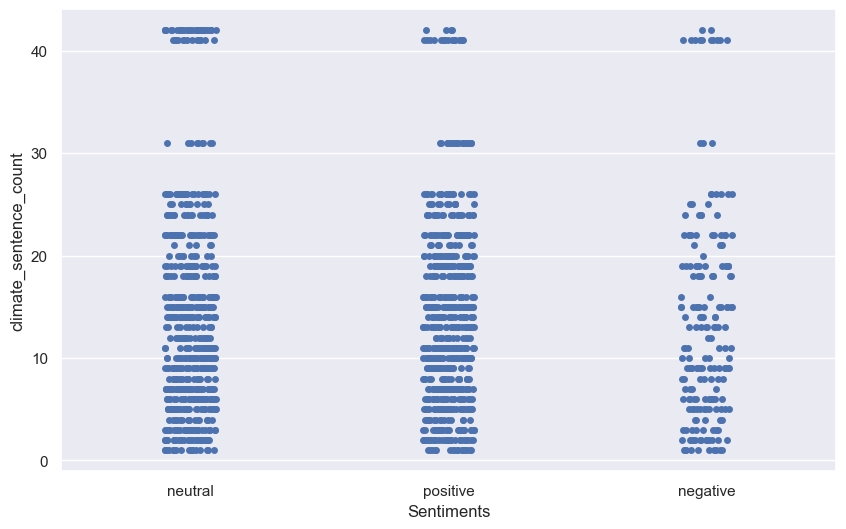

In [101]:
plt.figure(figsize=(10,6))
sns.stripplot(x='Sentiments', y='oil_sentence_count', data=oil)
plt.show();

plt.figure(figsize=(10,6))
sns.stripplot(x='Sentiments', y='climate_sentence_count', data=climate)
plt.show();

### Who are the users who had negative sentiments & a high retweet count ?

In [34]:
oil_sentiments[(oil_sentiments['Sentiments']=='negative')].head(10)

,date,oil_sentence_count,text,word_count,Stemd_text,Sentiments
0,1982-06-09,3,stark gash border separates german people,15,stark gash border separ german peopl,negative
15,2022-03-01,13,one stationed bases breathing toxic smoke burn...,25,one station base breath toxic smoke burn pit i...,negative
19,2020-03-13,9,based price oil also instructed secretary ener...,33,base price oil also instruct secretari energi ...,negative
20,2020-03-13,9,based price oil also instructed secretary ener...,33,base price oil also instruct secretari energi ...,negative
25,2020-03-13,9,guys selling lot toilet paper,10,guy sell lot toilet paper,negative
26,2020-03-13,9,know seems tony need give guidance toilet pape...,27,know seem toni need give guidanc toilet paper ...,negative
27,1991-01-16,1,world brutality lawlessness allowed go uncheck...,49,world brutal lawless allow go uncheck kind wor...,negative
28,2016-05-15,5,today join long line scarlet knights whose ene...,25,today join long line scarlet knight whose ener...,negative
30,2016-05-15,5,less dependent foreign oil,6,less depend foreign oil,negative
43,1975-04-23,5,goal make america independent foreign energy s...,13,goal make america independ foreign energi sour...,negative


In [11]:
import pandas as pd
oil = pd.read_csv('oil_sentences.csv')
oil_sentiments = pd.read_csv('oil_sentiment.csv')

In [40]:
# extract row 704's oil_sentences
oil.loc[27]

date                                                         1991-01-16
oil_sentence_count                                                    1
oil_sentences         A world in which brutality and lawlessness are...
Name: 27, dtype: object

In [110]:
# save the cleaned data
oil.to_csv('oil_sentiment.csv', index=False)
climate.to_csv('climate_sentiment.csv', index=False)

In [115]:
# plot sentiment over time

oil['date'] = pd.to_datetime(oil['date'])
climate['date'] = pd.to_datetime(climate['date'])

# map the sentiment to a numerical value
sentiment_map = {'positive': 1, 'negative': -1, 'neutral': 0}
oil['sentiment'] = oil['Sentiments'].map(sentiment_map)
climate['sentiment'] = climate['Sentiments'].map(sentiment_map)

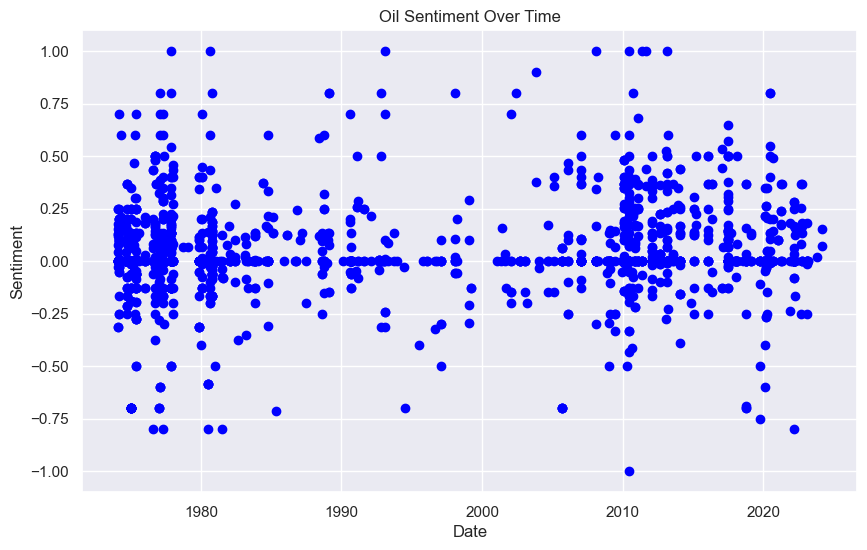

In [90]:
# group by date and calculate the average sentiment
oil_sentiment = oil.groupby('date').mean().reset_index()

oil['date'] = pd.to_datetime(oil['date'])
oil_sentiment['date'] = pd.to_datetime(oil_sentiment['date'])
oil_sentiment['sentiment_absolute'] = np.abs(oil_sentiment['Sentiments'])

# plot the sentiment over time
plt.figure(figsize=(10,6))
plt.scatter(oil['date'], oil['Sentiments'], color='blue')
plt.title('Oil Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.show()

In [103]:
# get the average of sentiments for positive and negative
oil_positive = oil[oil['Sentiments'] > 0]
oil_negative = oil[oil['Sentiments'] < 0]

oil_positive_avg = oil_positive['Sentiments'].mean()
oil_negative_avg = oil_negative['Sentiments'].mean()

# use t-test to determine if the difference is significant
from scipy.stats import ttest_rel
from scipy import stats

statistic, p_value = stats.wilcoxon(oil_positive['Sentiments'], oil_negative['Sentiments'])

# Print results
print("Wilcoxon signed-rank test results:")
print("Test statistic:", statistic)
print("p-value:", p_value)

# get the average oil sentiment over time
oil_avg = oil['Sentiments'].mean()

# flatten the data and plot sentiment
oil['Sentiments'].plot(kind='hist', bins=50, title='Oil Sentiment Distribution')

ValueError: The samples x and y must have the same length.

In [100]:
# check if the distribution is normal
from scipy.stats import normaltest

p = normaltest(oil['Sentiments']).pvalue

# test if mean is significantly different from 0


1.510224803123241e-39

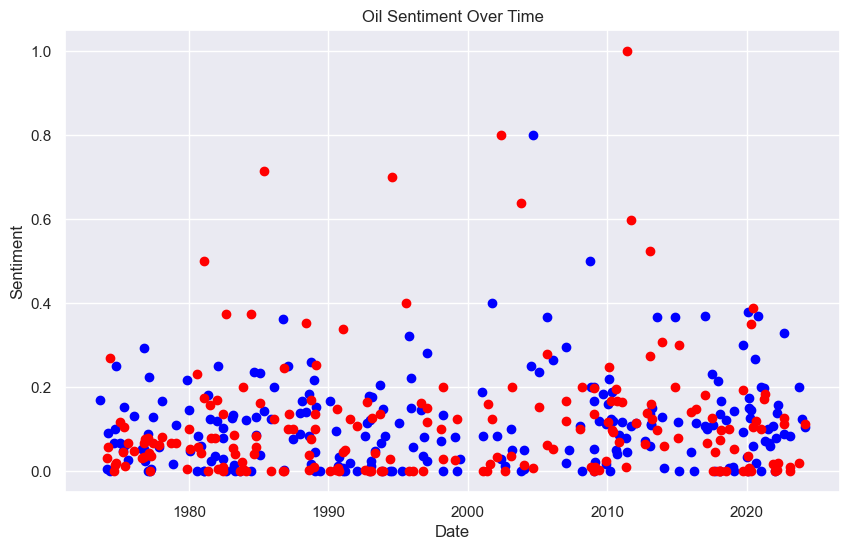

In [78]:
# group by date and calculate the average sentiment
climate_sentiment = climate.groupby('date').mean().reset_index()

climate_sentiment['date'] = pd.to_datetime(climate_sentiment['date'])
climate_sentiment['sentiment_absolute'] = np.abs(climate_sentiment['Sentiments'])

# plot the sentiment over time
plt.figure(figsize=(10,6))
plt.scatter(climate_sentiment['date'], climate_sentiment['sentiment_absolute'], color='blue')
plt.scatter(oil_sentiment['date'], oil_sentiment['sentiment_absolute'], color='red')
plt.title('Oil Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.show()

In [121]:
climate_sentiment = climate.groupby('date').mean().reset_index()

climate_sentiment['date'] = pd.to_datetime(climate_sentiment['date'])

oil_sentiment = oil.groupby('date').mean().reset_index()

oil_sentiment['date'] = pd.to_datetime(oil_sentiment['date'])
oil_sentiment

,date,oil_sentence_count,word_count,Sentiments
0,1974-01-30,21.0,35.047619,0.032619
1,1974-02-25,43.0,43.325581,0.057000
2,1974-04-29,3.0,26.000000,0.270667
3,1974-08-09,1.0,8.500000,0.000000
4,1974-09-18,14.0,24.214286,0.015143
...,...,...,...,...
196,2022-09-21,8.0,28.125000,0.127750
197,2023-02-07,8.0,17.000000,-0.009750
198,2023-02-21,2.0,12.500000,0.000000
199,2023-10-20,1.0,180.000000,0.019000


In [120]:
sentiment

,date,Sentiments_oil,Sentiments_climate
0,1974-01-30,0.032619,-0.004667
1,1974-02-25,0.057000,0.092200
2,1974-04-29,0.270667,0.000000
3,1974-09-18,0.015143,-0.100000
4,1974-10-08,0.020277,0.251143
...,...,...,...
175,2022-09-01,0.113000,0.328667
176,2022-09-21,0.127750,0.089871
177,2023-02-07,-0.009750,0.084000
178,2023-10-20,0.019000,0.200000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


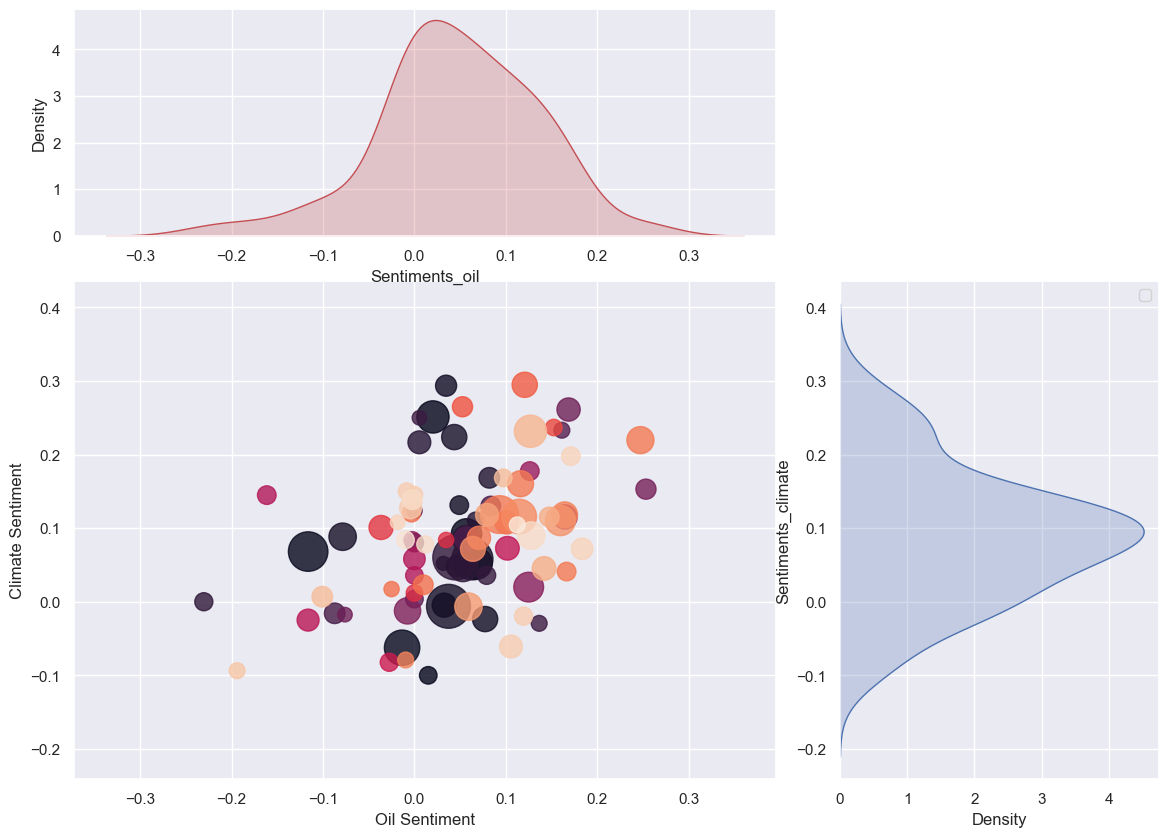

,Sentiments_oil_abs,Sentiments_climate_abs
Sentiments_oil_abs,1.000000,0.146124
Sentiments_climate_abs,0.146124,1.000000


In [150]:
# find correlation between oil and climate sentiment
sentiment = oil_sentiment.merge(climate_sentiment, on='date', suffixes=('_oil', '_climate'))
sentiment['sentence_count'] = sentiment['oil_sentence_count'] + sentiment['climate_sentence_count']
sentiment = sentiment[sentiment['sentence_count'] > 10]

sentiment['year'] = sentiment['date'].dt.year

# plot the two sentiments against each other
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(3, 3)
ax = plt.subplot(gs[1:3, :2])
ax_oil = plt.subplot(gs[0, :2],sharex=ax)
ax_climate = plt.subplot(gs[1:3, 2],sharey=ax)
ax.scatter(sentiment['Sentiments_oil'], sentiment['Sentiments_climate'], c = sentiment['year'], s = 10*sentiment['sentence_count'], alpha = 0.8)
# plt.title('Oil Sentiment vs Climate Sentiment')
ax.set(xlabel="Oil Sentiment", ylabel="Climate Sentiment")
plt.legend()

# add distributions of climate sentiment and oil sentiment on the sides
sns.kdeplot(sentiment['Sentiments_oil'], shade=True, color='r', label='Oil Sentiment', ax = ax_oil)

sns.kdeplot(sentiment['Sentiments_climate'], shade=True, color='b', label='Climate Sentiment', ax = ax_climate, vertical=True)

plt.show()

# get correlation between the absolute values of the two sentiments
sentiment['Sentiments_oil_abs'] = np.abs(sentiment['Sentiments_oil'])
sentiment['Sentiments_climate_abs'] = np.abs(sentiment['Sentiments_climate'])
sentiment[['Sentiments_oil_abs', 'Sentiments_climate_abs']].corr()

The p-value for the F-test is: 0.0002953030694227602.
The model is statistically significant.


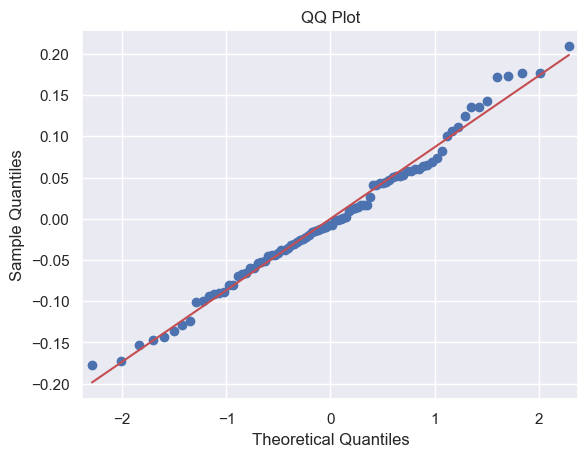

The null hypothesis for the Jarque-Bera test is normality.
{'Jarque-Bera': 0.9042176804357266, 'Chi^2 two-tail prob.': 0.6362849125676664, 'Skew': 0.23470309081228152, 'Kurtosis': 2.8558384536864696}


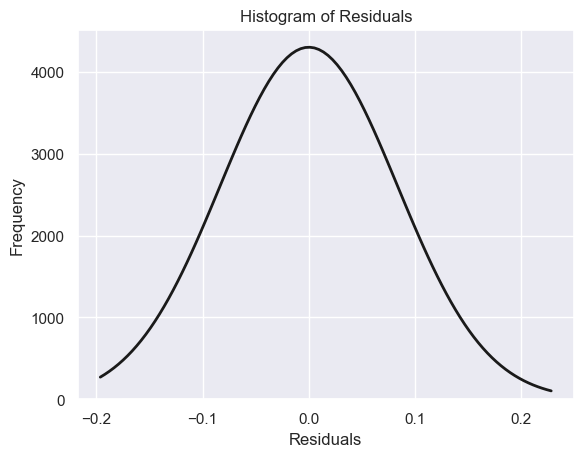

The residuals are normally distributed.
The null hypothesis for the Breusch-Pagan test is homoscedasticity.
{'Lagrange multiplier statistic': 0.0005527482170675224, 'p-value': 0.9812429848621319, 'f-value': 0.0005404682427197462, 'f p-value': 0.9815051069759749}


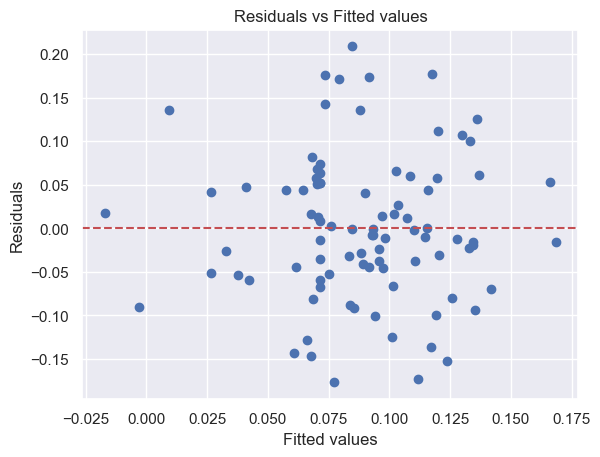

The residuals are homoscedastic.
The null hypothesis for the Durbin-Watson test is no autocorrelation.
{'Durbin-Watson': 2.078372917799217, 'p-value': 0.037675025108710125}


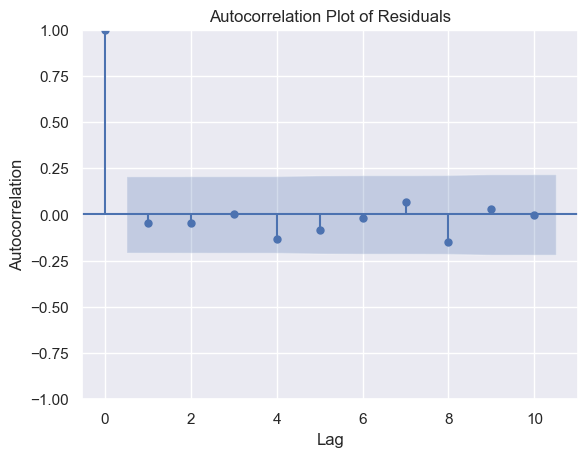

The residuals are autocorrelated.
The correlation matrix is:


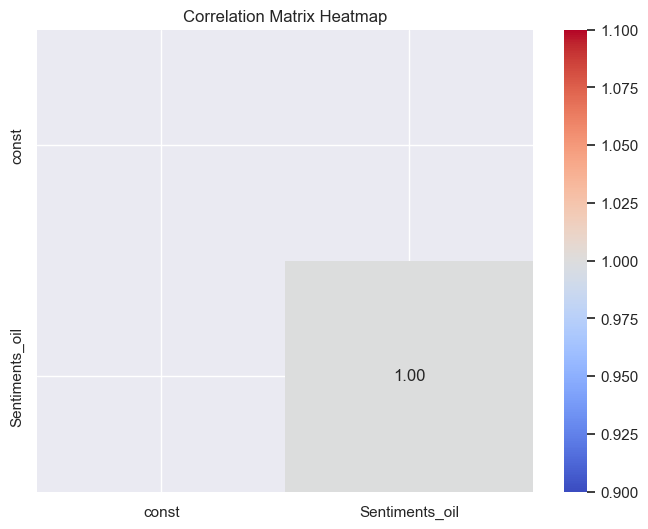

         Variable      VIF
0           const  1.28071
1  Sentiments_oil  1.00000
There is no multicollinearity in the model.
The model passes all the assumptions.
                            OLS Regression Results                            
Dep. Variable:     Sentiments_climate   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     14.21
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           0.000295
Time:                        16:56:57   Log-Likelihood:                 95.782
No. Observations:                  90   AIC:                            -187.6
Df Residuals:                      88   BIC:                            -182.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t

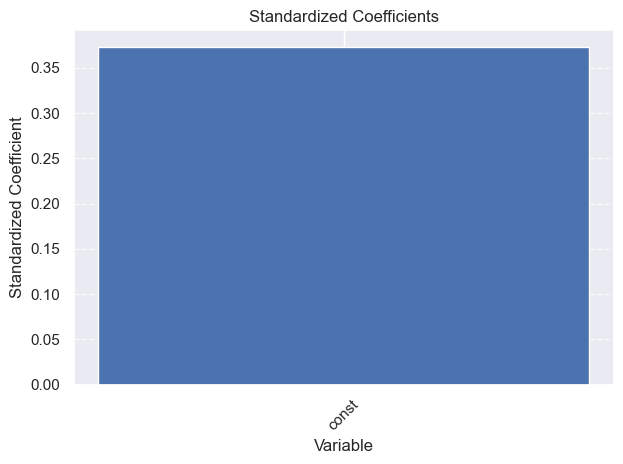

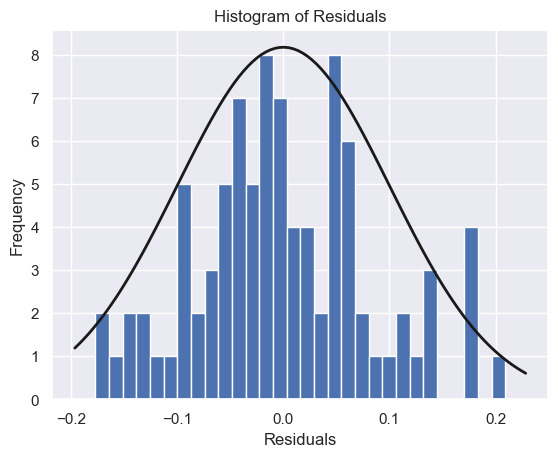

In [159]:
model = test_linear_model(X,y)
def plot_residuals(model):
    plt.hist(model.resid, bins=30)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')
    # fit a normal curve to the histogram of residuals
    mu, std = 0, 0.1
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p * 8/5/5*8/10*8, 'k', linewidth=2)
    plt.show()

plot_residuals(model)


The p-value for the F-test is: 0.0002953030694227602.
The model is statistically significant.


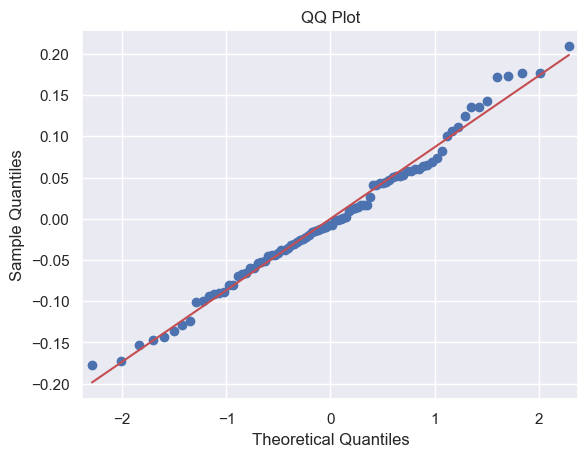

The null hypothesis for the Jarque-Bera test is normality.
{'Jarque-Bera': 0.9042176804357266, 'Chi^2 two-tail prob.': 0.6362849125676664, 'Skew': 0.23470309081228152, 'Kurtosis': 2.8558384536864696}


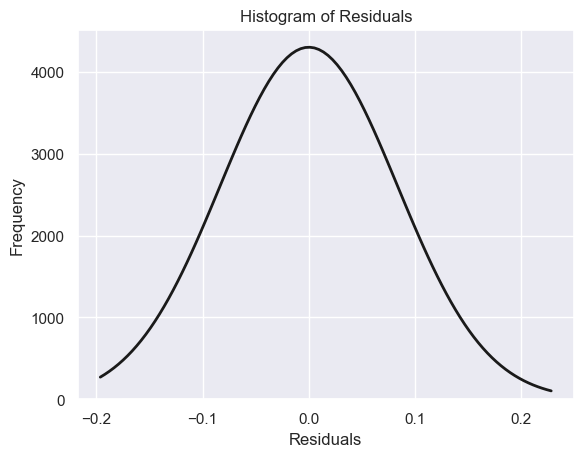

The residuals are normally distributed.
The null hypothesis for the Breusch-Pagan test is homoscedasticity.
{'Lagrange multiplier statistic': 0.0005527482170675224, 'p-value': 0.9812429848621319, 'f-value': 0.0005404682427197462, 'f p-value': 0.9815051069759749}


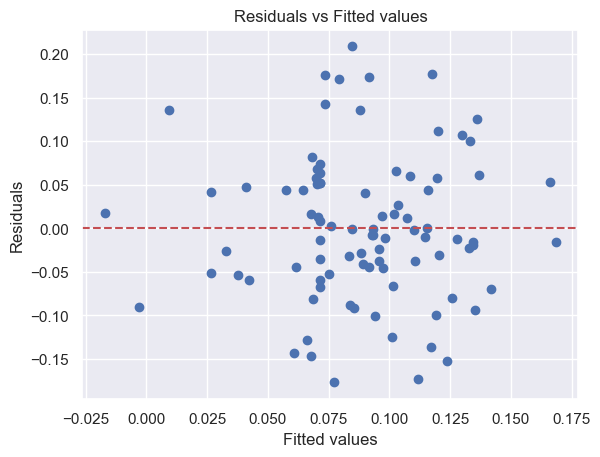

The residuals are homoscedastic.
The null hypothesis for the Durbin-Watson test is no autocorrelation.
{'Durbin-Watson': 2.078372917799217, 'p-value': 0.037675025108710125}


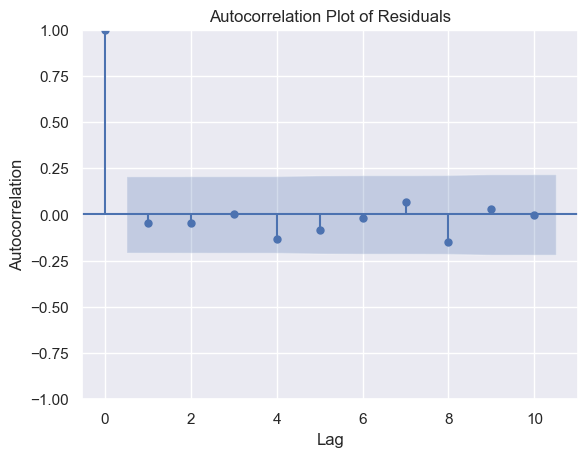

The residuals are autocorrelated.
The correlation matrix is:


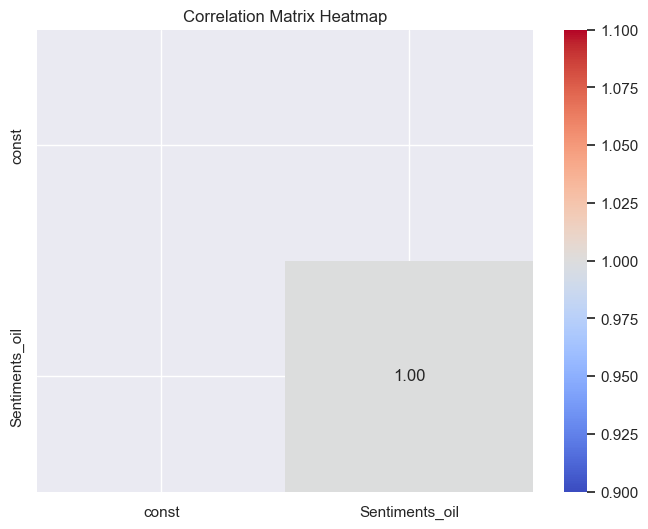

         Variable      VIF
0           const  1.28071
1  Sentiments_oil  1.00000
There is no multicollinearity in the model.
The model passes all the assumptions.
                            OLS Regression Results                            
Dep. Variable:     Sentiments_climate   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     14.21
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           0.000295
Time:                        15:53:20   Log-Likelihood:                 95.782
No. Observations:                  90   AIC:                            -187.6
Df Residuals:                      88   BIC:                            -182.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t

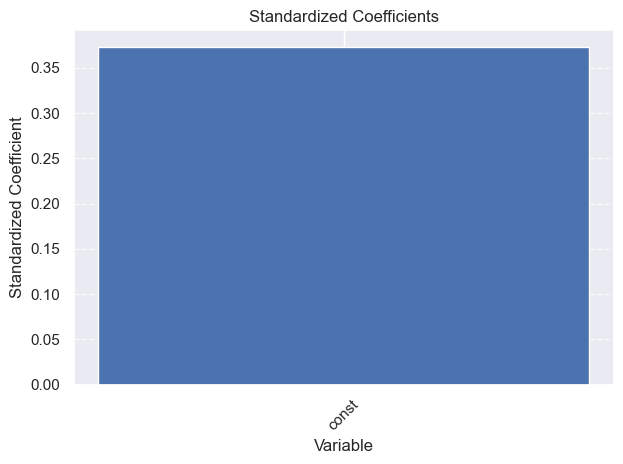

In [152]:
# get the correlation between the two sentiments for the filtered data
X = sentiment['Sentiments_oil']
y = sentiment['Sentiments_climate']
test_linear_model(X, y)

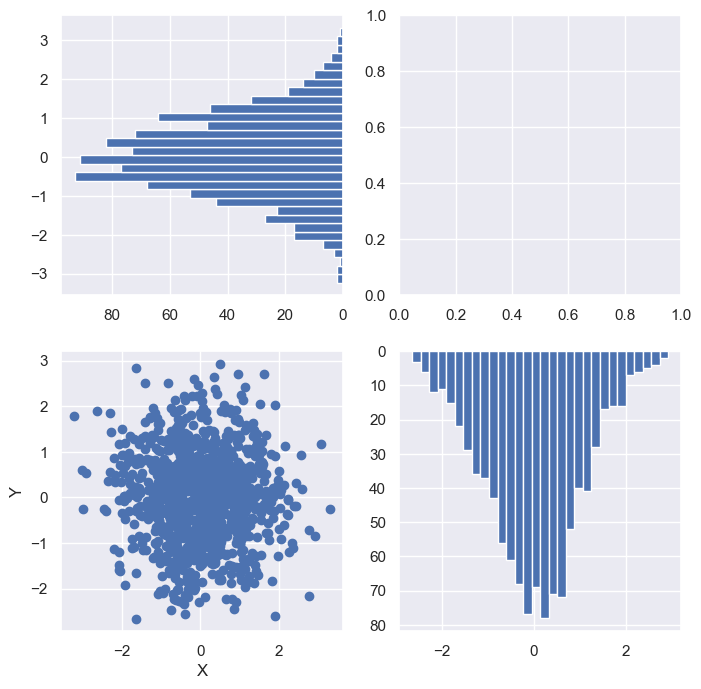

In [128]:
import matplotlib.pyplot as plt
import numpy as np

# Create some data
x = np.random.normal(0, 1, 1000)
y = np.random.normal(0, 1, 1000)

# Create a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Plot the main scatter plot
axs[1, 0].scatter(x, y)
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')

# Plot the distribution of x on top
axs[0, 0].hist(x, bins=30, orientation='horizontal')
axs[0, 0].invert_xaxis()

# Plot the distribution of y on the right
axs[1, 1].hist(y, bins=30, orientation='vertical')
axs[1, 1].invert_yaxis()

plt.show()

In [107]:
from LinearModel import *

X, y = sentiment['Sentiments_oil'], sentiment['Sentiments_climate']

model = test_linear_model(X, y)

The p-value for the F-test is: 0.9933786507607177.
The model is not statistically significant.


In [89]:
# identify the speech with the lowest climate sentiment
climate.sort_values('Sentiments').tail(1)['text']

1302    another part future greatest challenge reduce ...
Name: text, dtype: object

In [86]:
# identify the speech with the lowest oil sentiment and highest word count
oil.sort_values('Sentiments').tail(1)

,date,oil_sentence_count,text,word_count,Stemd_text,Sentiments
1154,2013-02-13,28,states best ideas create jobs lower energy bil...,27,state best idea creat job lower energi bill co...,1.0
